In [1]:
import pointCollection as pc
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.ndimage as snd

In [2]:
data_root='/Volumes/ice2/ben/openTopography/Boulder'

In [7]:
%matplotlib notebook

In [4]:
def read_data(thefile, **geotif_args):
    rms_file=thefile.replace('.tif','_rms_30m.tif')
    sm_file=thefile.replace('.tif','_sm_5m.tif')
    if os.path.isfile(rms_file):
        print('READING:')
        D=pc.grid.data().from_geotif(thefile, **geotif_args)
        temp=pc.grid.data().from_geotif(rms_file, **geotif_args)
        D.assign({'z_rms_30m':temp.z})
        temp=pc.grid.data().from_geotif(sm_file, **geotif_args)
        D.assign({'zs':temp.z})
    else:
        print('SMOOTHING to 5m:')
        D=pc.grid.data().from_geotif(thefile)
        # nodata is sometimes set wrong:
        D.z[np.abs(D.z) > 1.e4] = np.NaN 
        K_fp=np.exp(-(np.arange(-15, 16)**2/2/4.25**2))
        K_fp=K_fp.reshape([K_fp.size,1])
        K_fp /= K_fp.sum()
        D.assign({'zs':snd.convolve(snd.convolve(D.z, K_fp), K_fp.T)})
        print('smoothing RMS to 30m')
        D.to_geotif(thefile.replace('.tif','_sm_5m.tif'), field='zs', srs_epsg=26913)
        K_30m = np.exp(-(np.arange(-100, 101)**2/2/30**2))
        K_30m=K_30m.reshape([K_30m.size,1])
        K_30m /= K_30m.sum()
        D.assign({'z_rms_30m':np.sqrt(snd.convolve(snd.convolve((D.zs-D.z)**2, K_30m), K_30m.T))})
        D.to_geotif(thefile.replace('.tif','_rms_30m.tif'), field='z_rms_30m', srs_epsg=26913)
        
    return D

In [54]:
# pick a smallish area in the corner of the DEM:
XR=[441000., 445000.]
YR=[4419000., 4423000.]

D_bare_sub=read_data('/Volumes/ice2/ben/openTopography/Boulder/snow_off/08.21.10/BcCZO_DTM_SnOff.tif', bounds=[XR, YR])


READING:
bounds=[[441000.0, 445000.0], [4419000.0, 4423000.0]]
bounds=[[441000.0, 445000.0], [4419000.0, 4423000.0]]
bounds=[[441000.0, 445000.0], [4419000.0, 4423000.0]]


<IPython.core.display.Javascript object>


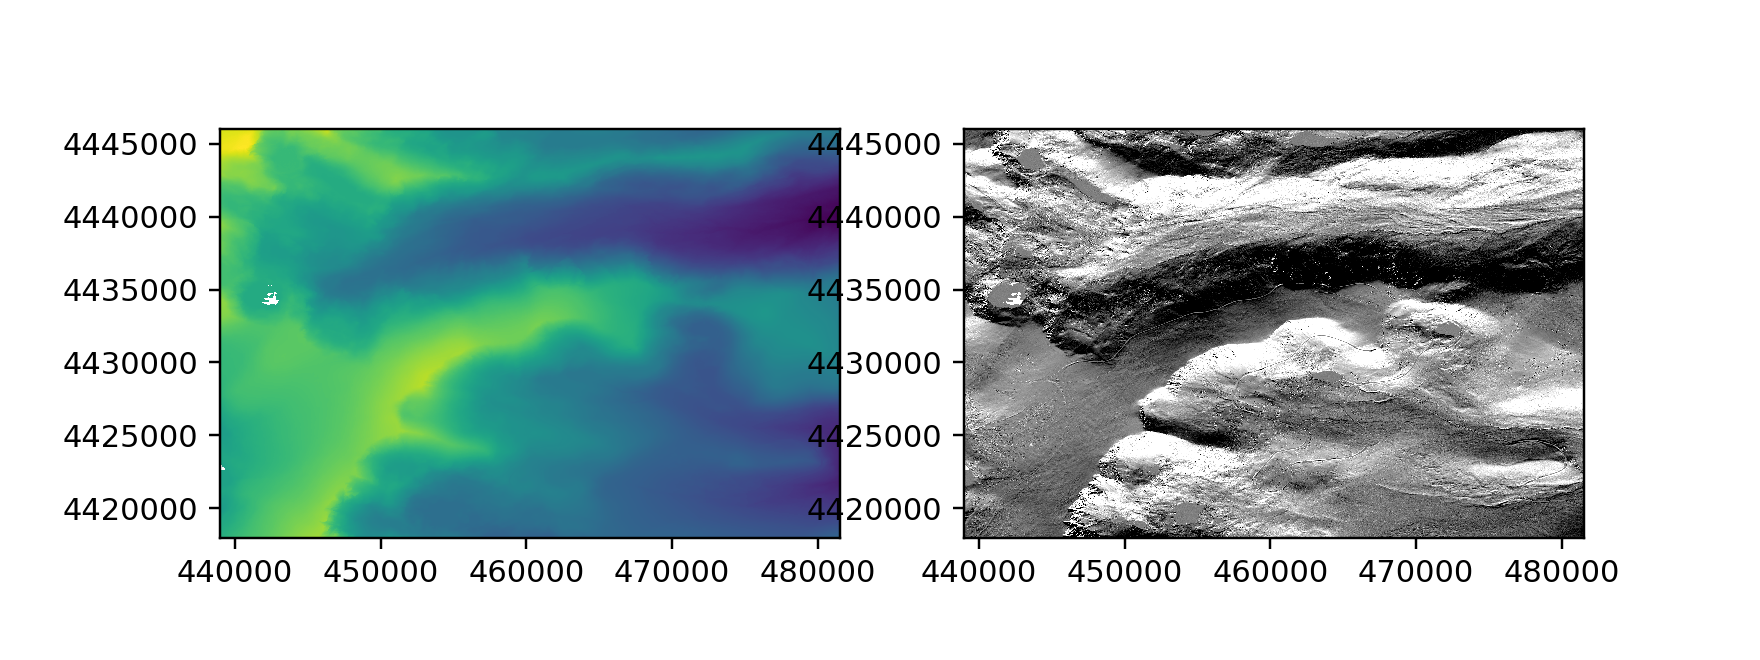

In [199]:
fig=plt.figure(figsize=[8,3]); 
hax=fig.add_subplot(121)
plt.imshow(D_bare_sub.z, origin='lower', extent=D_bare.extent)
dzdx, dzdy=np.gradient(D_bare_sub.z)
hax=fig.add_subplot(122)
plt.imshow(dzdx, origin='lower', extent=D_bare.extent, cmap='gray', clim=[-0.5, 0.5])



We would like to calculate a linear segment fit to the topography for a large number of points in the DEM.  This is fairly straightforward to implement in terms of convolutions.  Consider the matrix implementation of a least-squares linear fit to $z = \mathbf{G} \mathbf{m}$, where
$$ \mathbf{G} = [\delta, 1]$$
and
$$ \mathbf{m} = [z_x, z_0]$$
here $\delta$ are N x offsets spanning $[-W, W]$.  This has the solution:
$$ \mathbf{m} = \mathbf{G}^{-g} z$$
where
$$ \mathbf{G}^{-g} = (\mathbf{G}^T \mathbf{G})^{-1}\mathbf{G}^T$$
$\mathbf{G}^{-g}$ is a 2xN matrix, which lets us implement the fit at each point as:
$$ z_x = G^g_{0,i} *_x z$$
$$ z_0 = G^g_{1,i} *_x z$$
Here $G^g_{0,i}$ is the first row of $ \mathbf{G}^{-g} $, and $*_xz$ denotes a convolution of a row vector with map $z$.  The fit in $y$ can be calculated by doing the same convolution in the y direction.

In [140]:
def calc_slope_fit(z, W, spacing, orientation='y'):
    N=int(W/spacing)
    G=np.c_[np.arange(-(N-1)/2, (N-1)/2+1), np.ones(N)]
    Ginv=np.linalg.inv(G.T.dot(G)).dot(G.T)
    # need to reverse the delta kernel to get the slope to come out right. 
    m_kernel=Ginv[0,::-1].reshape([1,N])
    b_kernel=Ginv[1,::-1].reshape([1,N])
    if orientation=='y':
        m_kernel=m_kernel.T
        b_kernel=b_kernel.T
    slope=snd.convolve(z, m_kernel)
    intercept=snd.convolve(z, b_kernel)
    return slope, intercept

The formula for the misfit to the plane fit follows a similar form: At any point, the squared misfit is:
$$ N \sigma_{seg}^2 = \sum_i ((z_x \delta_i +z_0 ) - z_i)^2 $$
Expanding the right-hand side gives:
$$ = z_x^2 \sum_i \delta_i^2 + 2 z_x z_0 \sum_i \delta_i - 2 z_x \sum_i \delta_i z_i - 2 z_0 \sum_i z_i + N z_0^2 + \sum_i z_i^2$$
This has the form of a set of convolutions:
$$ = z_x^2 \sum_i \delta_i^2  + 2 z_x z_0 \sum_i \delta_i - 2 z_x (z *_x \delta) - 2 b (z^2 *_x \mathbf{1}) + (z^2 *_x \mathbf{1})$$
Here $\mathbf{1}$ denotes a vector of N unit values.

In [155]:
def calc_slope_misfit(z, W, spacing, m=None, b=None, orientation='y'):
    if m is None:
        m, b = calc_slope_misfit(z, W, spacing, orientation=orientation)
    
    N=int(W/spacing)
    G=np.c_[np.arange(-(N-1)/2, (N-1)/2+1)*spacing, np.ones(N)]
    # need to reverse the delta kernel to get the slope to come out right.  
    delta_kernel=G[::-1,0].reshape([1,N])
    ones_kernel =G[:,1].reshape([1,N])
    if orientation=='y':
        delta_kernel=delta_kernel.T
        ones_kernel=ones_kernel.T
    misfit2 = m**2 * np.sum(delta_kernel**2)  \
        +2*m*b*np.sum(delta_kernel)\
        -2*m*snd.convolve(z, delta_kernel)  \
        -2*b*snd.convolve(z, ones_kernel) \
        + N*b**2 \
        + snd.convolve(z**2, ones_kernel)
    return np.sqrt(misfit2/N)

Run the calculation with an ATL06-sized segment:

In [156]:
mx, b = calc_slope_fit(D_bare_sub.z, 39, 1, orientation='x')
sigma_x=calc_slope_misfit(D_bare_sub.z, 39, 1, m=mx, b=b, orientation='x')
sigma_fp = np.sqrt(snd.convolve((D_bare_sub.z-D_bare_sub.zs)**2, np.ones([1, 39])/39))

<IPython.core.display.Javascript object>


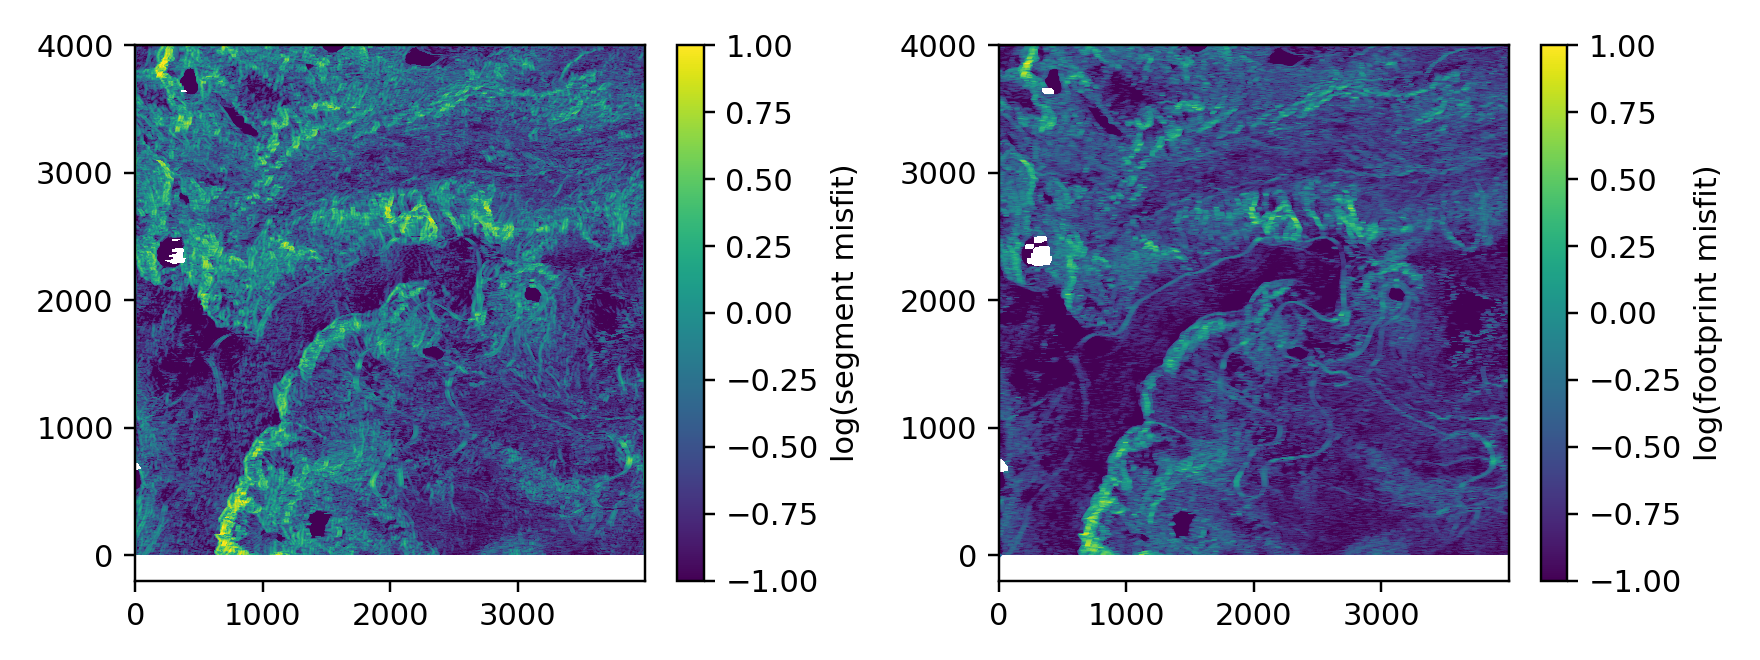

In [159]:
fig=plt.figure(figsize = [8,3]); 
hax0=fig.add_subplot(121)
hi=hax0.imshow(np.log10(sigma_x), origin='lower', clim=[-1, 1]); 
plt.colorbar(hi, label='log(segment misfit)')
hax1 =fig.add_subplot(122, sharex=hax0, sharey=hax0)
hi=hax1.imshow(np.log10(sigma_fp), origin='lower', clim=[-1, 1]); 
plt.colorbar(hi, label='log(footprint misfit)')
plt.tight_layout()

The error in the intercept of a linear fit centered around zero is just $\sigma_d N^{-1/2}$ (Could do this analytically, but here's a cell demonstrating the fit:

<IPython.core.display.Javascript object>


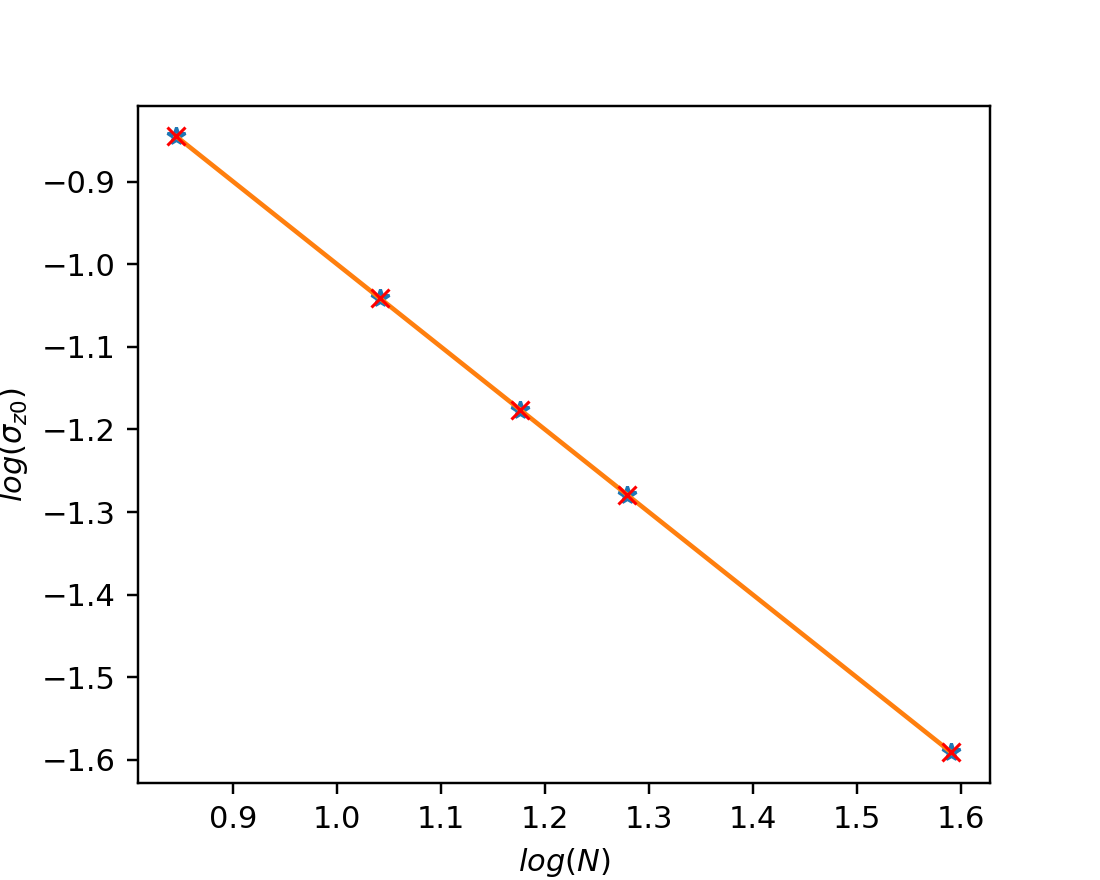

[-1.00000000e+00  2.22044605e-15]


In [246]:
# spacing is arbitrary, but this cell can be run with different spacing
spacing=1
W_vals=np.array([ 7, 11, 15,  19, 39])*spacing
sigma_z_vals=[]
for W in W_vals:
    N=int(W/spacing)
    G=np.c_[np.arange(-(N-1)/2, (N-1)/2+1)*spacing, np.ones(N)]
    Ginv=np.linalg.inv(G.T.dot(G)).dot(G.T)
    cm=Ginv.dot(Ginv.T)
    sigma_z_vals += [cm[1,1]]
plt.figure(figsize=[5,4]);
plt.plot(np.log10(W_vals), np.log10(np.array(sigma_z_vals)),'*')
G_logfit = np.c_[np.log10(W_vals/spacing), np.ones(len(W_vals))]
m_logfit = (np.linalg.inv(G_logfit.T.dot(G_logfit)).dot(G_logfit.T)).dot(np.log10(np.array(sigma_z_vals)))
print(m_logfit)
plt.plot(np.log10(W_vals), G_logfit.dot(m_logfit))
plt.plot(np.log10(W_vals), -np.log10(W_vals/spacing),'rx')
plt.xlabel('$log(N)$');
plt.ylabel('$log(\sigma_{z0}$)');

This gives lets us calculate the error in the linear fit as a function of the width of the fit, using
$N = W/0.7 * N_{ph}$ and $\sigma^2 = \sigma_{fit}^2 + \sigma_{fp}^2 + \sigma_{wf}^2$:
$$\sigma_{z0} = \left(\frac{\sigma_{fit}^2 + \sigma_{fp}^2 + \sigma_{wf}^2}{W/0.7 * N_{ph}}\right)^{1/2}$$
where $\sigma_{wf}$ is the temporal duration of the laser pulse, expressed in meters, and $N_{ph}$ is the number of photons returned per pulse.  Using 9 photons/pulse (reflectance 75% that of snow), $sigma_{wf}$=0.1 m, we can then map the expected error for different segment lengths:

In [ ]:
spacing=1
N_per_pulse=12*0.75
sigma_tot={}
W_vals=[9, 19, 29, 39]
for W in W_vals:
    mx, b = calc_slope_fit(D_bare_sub.z, W, 1, orientation='x')
    sigma_x=calc_slope_misfit(D_bare_sub.z, W, 1, m=mx, b=b, orientation='x')
    sigma_fp = np.sqrt(snd.convolve((D_bare_sub.z-D_bare_sub.zs)**2, np.ones([1, W])/W))
    sigma_tot[W]=np.sqrt((sigma_x**2+sigma_fp**2+0.1**2)/(W/0.7*N_per_pulse))


<IPython.core.display.Javascript object>


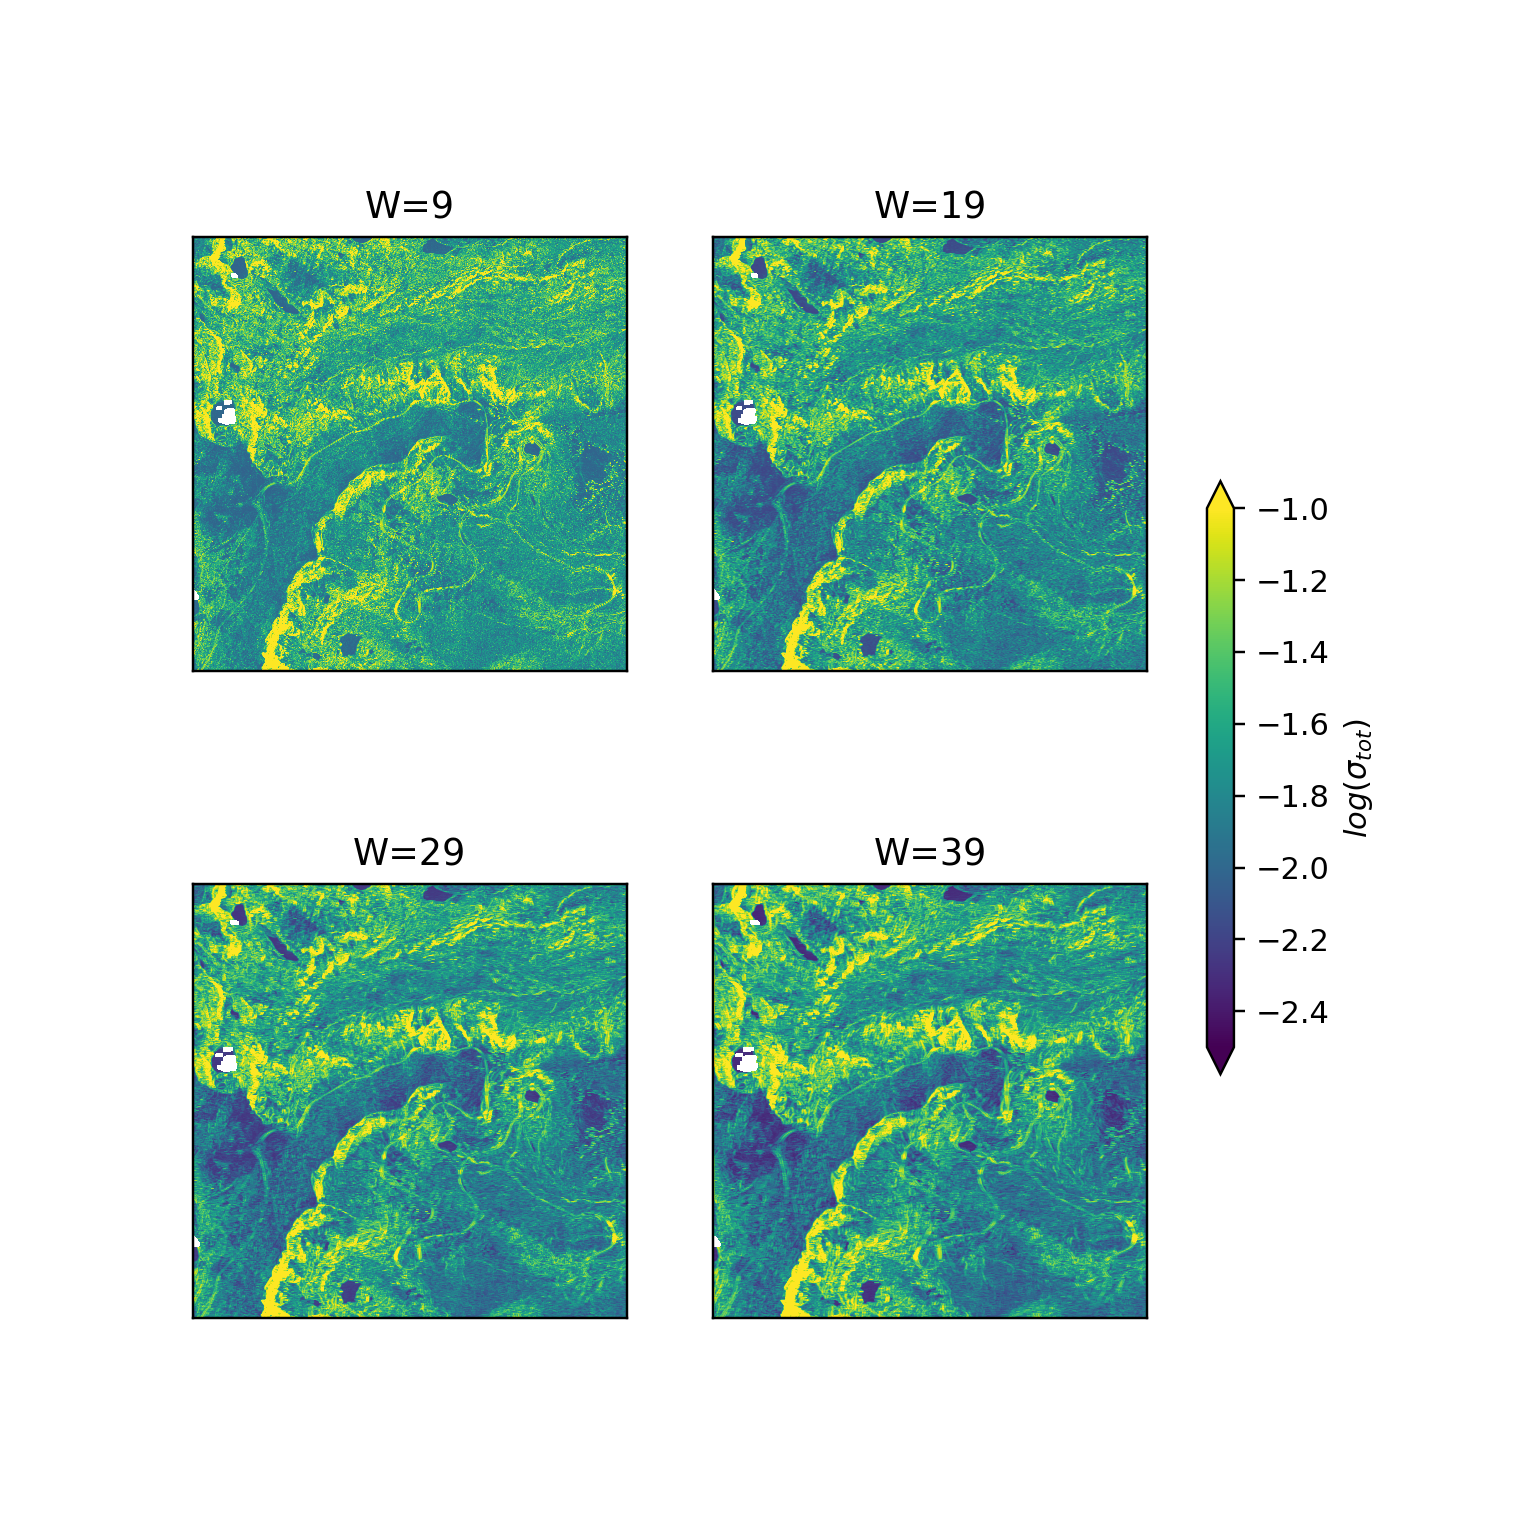

In [201]:
fig=plt.figure(figsize=[7,7])
hax=[None for Wi in W_vals]
for ii, W in enumerate(sigma_tot.keys()):
    if ii == 0:
        hax[ii]=fig.add_subplot(2,2,ii+1)
    else:
        hax[ii]=fig.add_subplot(2,2,ii+1, sharex=hax[0], sharey=hax[0])
    hi=hax[ii].imshow(np.log10(sigma_tot[W]), origin='lower', clim=[-2.5, -1])
    hax[ii].set_title(f'W={W}')
    hax[ii].set_xticks([])
    hax[ii].set_yticks([])
hb=plt.colorbar(hi, ax=tuple(hax), label='$log(\sigma_{tot})$', shrink=0.5, extend='both')

These maps are a little complicated, but the major features are that in smooth areas, the errors are smallest for long segments, while in rough areas (with significant large-scale relief) the errors are smalllest for the short segments.  Conversely, the in flat, smooth areas, the errors are smallest for long segments

### Snow thickness

Of course, it's always fun to see what's in the data. To do this, we'll read in the entire dataset, and decimate it to 5-meters, and look at differences in the smoothed elevation field. Here's a map of the difference between snow-on and snow-off surface height.  Looks like a good year for skiing!

In [ ]:
D_bare_interp_zs=D_bare.interp(D_snow.x, D_snow.y, field='zs', gridded=True)

<IPython.core.display.Javascript object>


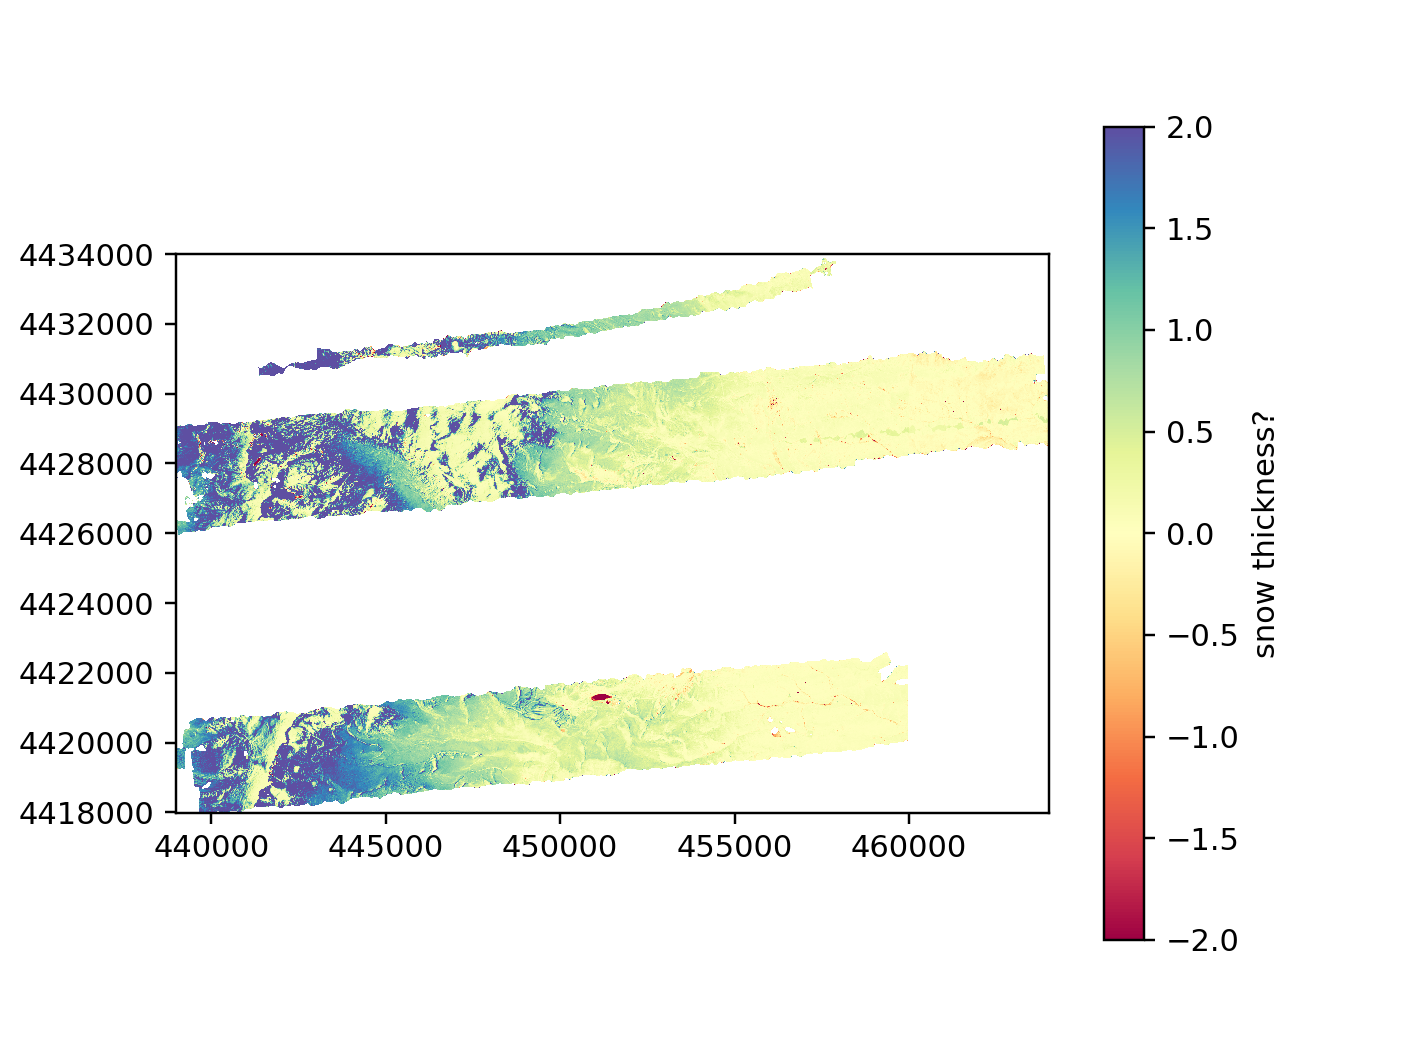

In [245]:
plt.figure(); plt.imshow(D_snow.zs-D_bare_interp_zs, origin='lower', extent=D_snow.extent, cmap='Spectral', clim=[-2, 2])
plt.colorbar(label='snow thickness?')

## Seasonal changes in surface roughness

The error analysis was for the snow-off DEM alone.  This is generally the worse of the two, contributing somewhat more error than the snow-on DEM.  We can see this by accumulating the 5-m RMS roughness to 30 m, and mapping the difference between the snow-on and snow-off roughness.

In [225]:
D_snow=read_data('/Volumes/ice2/ben/openTopography/Boulder/snow_on/05.05.10/BcCZO_DTM_20100505_SnOn.tif')[::5, ::5]
D_bare=read_data('/Volumes/ice2/ben/openTopography/Boulder/snow_off/08.21.10/BcCZO_DTM_SnOff.tif')[::5, ::5]
D_snow.z_rms_30m[D_snow.z_rms_30m>100]=np.NaN
D_bare.z_rms_30m[D_bare.z_rms_30m>100]=np.NaN

READING:
bounds=None
bounds=None
bounds=None
READING:
bounds=None
bounds=None
bounds=None


To do this, we'll have to interpolate one of the DEMs to match the other.  It turns out that the snow-on DEM is smaller, so we'll interpolate the bare DEM to the locations of the snow-on DEM

In [233]:
D_bare_interp=D_bare.interp(D_snow.x, D_snow.y, field='z_rms_30m', gridded=True)

Now we can look at the distribution of the roughness for the two:

<IPython.core.display.Javascript object>


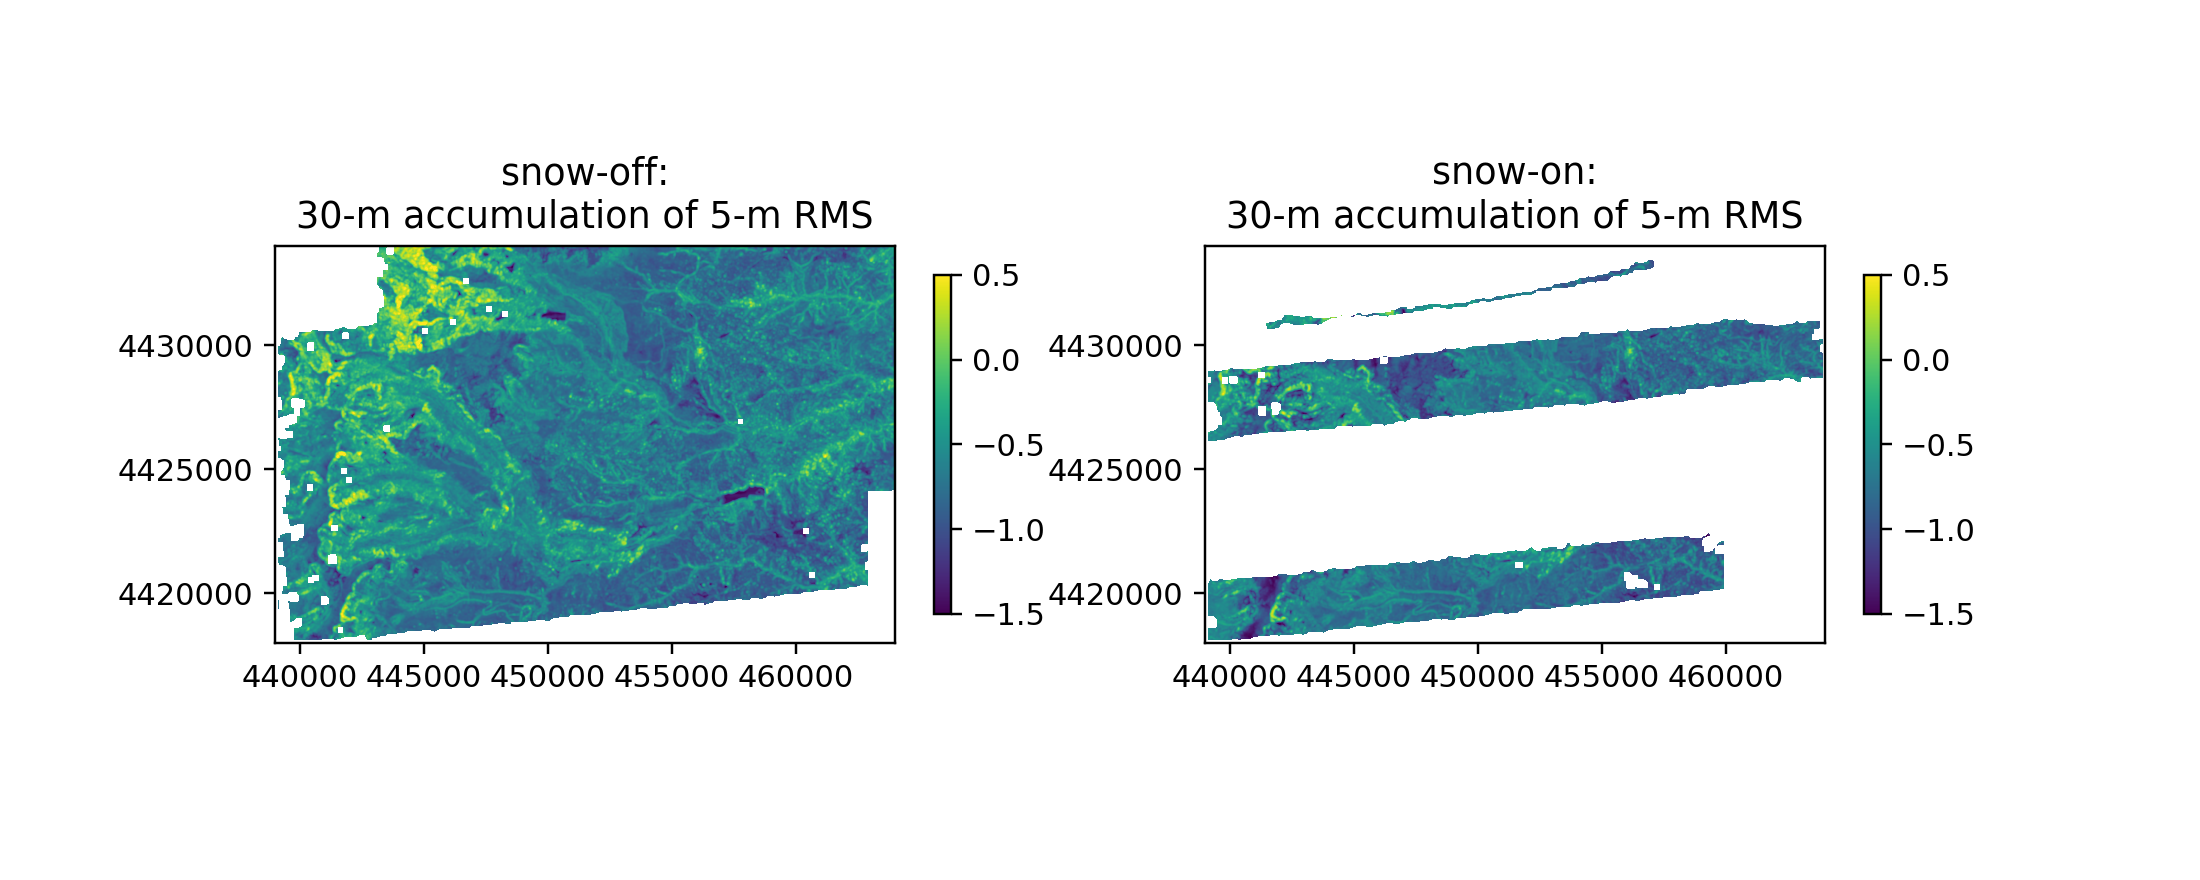

Text(0.5, 1.0, 'snow-on:\n30-m accumulation of 5-m RMS')

In [210]:
fig=plt.figure(figsize=[10,4]); 
ax0=fig.add_subplot(121)
plt.imshow(np.log10(D_bare.z_rms_30m), extent=D_bare.extent, clim=[-1.5, 0.5], origin='lower'); 
plt.colorbar(shrink=0.5)
plt.title('snow-off:\n30-m accumulation of 5-m RMS')
ax1=fig.add_subplot(122, sharex=ax0, sharey=ax0)
plt.imshow(np.log10(D_snow.z_rms_30m), extent=D_snow.extent, clim=[-1.5, 0.5], origin='lower'); 
plt.colorbar(shrink=0.5)
plt.title('snow-on:\n30-m accumulation of 5-m RMS')


The snow-on DEM is locally somewhat smoother than the snow-off DEM (see the flat area near 441000, 44190000).  We can map and make histograms of the difference:

<IPython.core.display.Javascript object>


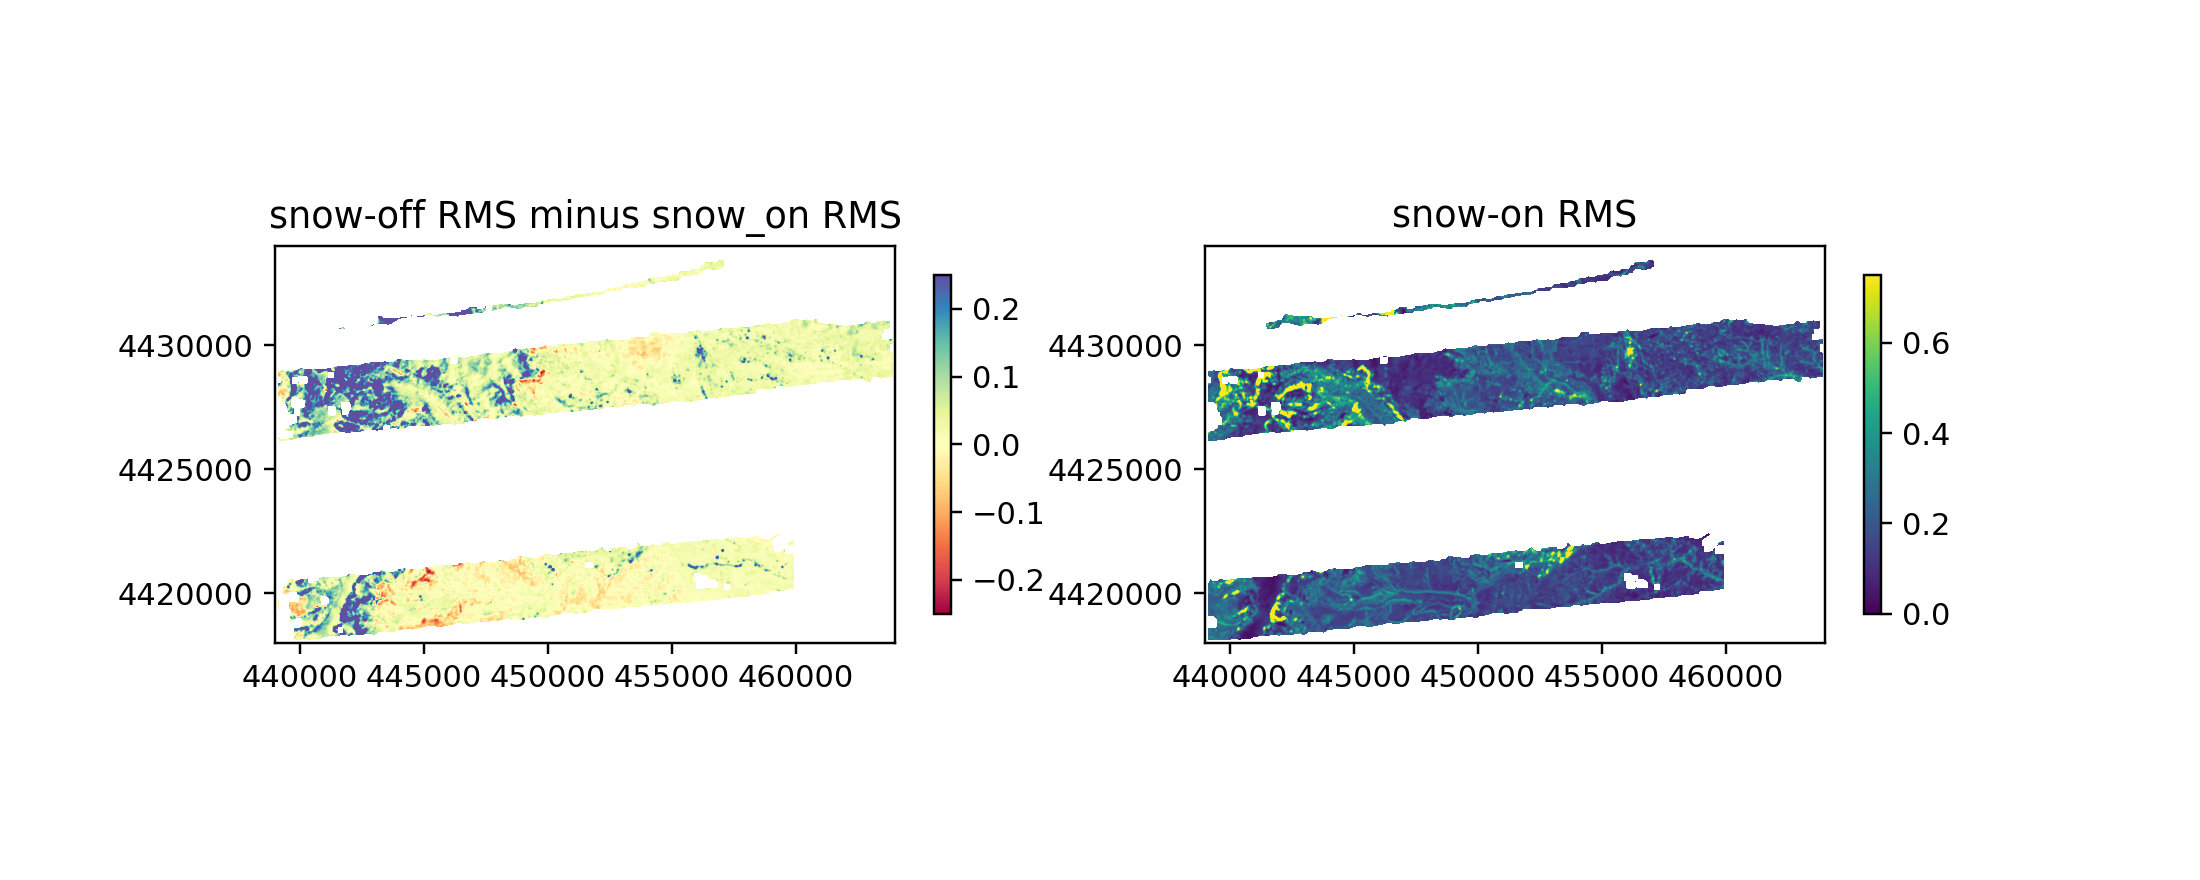

<IPython.core.display.Javascript object>


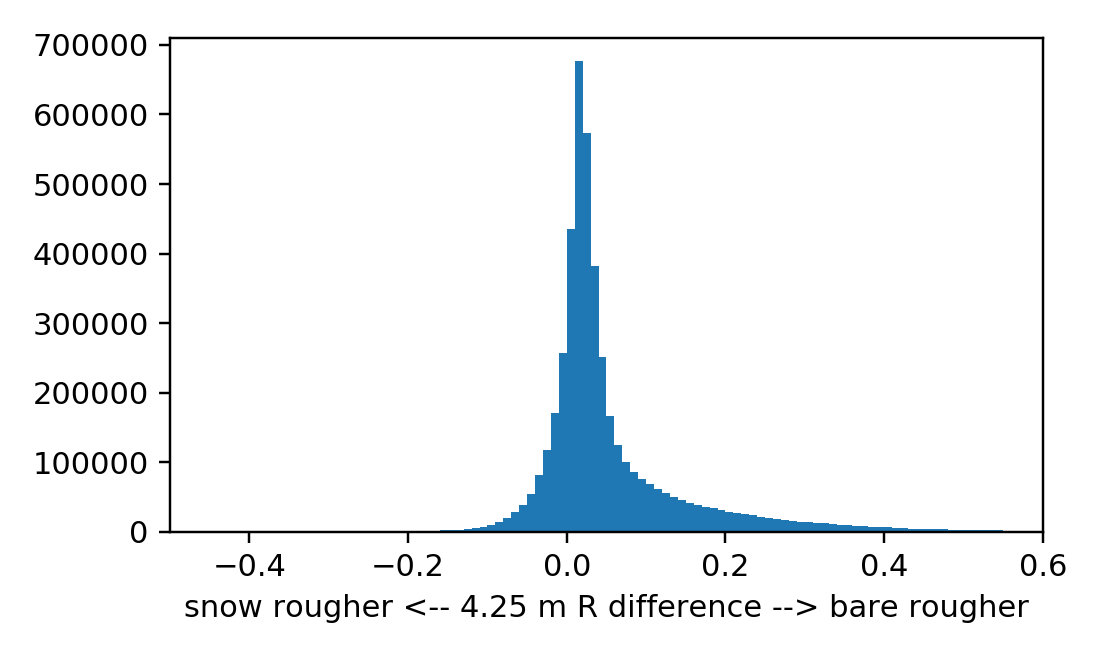

In [234]:
fig=plt.figure(figsize=[10,4]);
delta_rms = D_bare_interp-D_snow.z_rms_30m
#delta_rms[np.abs(delta_rms) > 1.e2]=np.NaN
ax0=fig.add_subplot(121)
plt.imshow(delta_rms, extent=D_snow.extent, origin='lower', clim=[-0.25, 0.25], cmap='Spectral'); 
plt.title('snow-off RMS minus snow_on RMS')
plt.colorbar(shrink=0.5)
ax1=fig.add_subplot(122, sharex=ax0, sharey=ax0)
plt.imshow(D_snow.z_rms_30m, extent=D_snow.extent, origin='lower', clim=[0, 0.75]); 
plt.title('snow-on RMS')
plt.colorbar(shrink=0.5)

plt.figure(figsize=[5, 3]); plt.hist(delta_rms[np.isfinite(delta_rms)], np.arange(-0.75, 0.75, 0.01))
plt.gca().set_xlim([-0.5, 0.6])
plt.xlabel('snow rougher <-- 4.25 m R difference --> bare rougher');
plt.tight_layout()


In [3]:
! ls /Volumes/ice2/ben/openTopography/Boulder/snow_off/08.21.10


BcCZO_DTM_SnOff_az_fft2.tif  BcCZO_DTM_SnOff_sm_5m.tif
BcCZO_DTM_SnOff_P_fft2.tif   BcCZO_DTM_SnOff.tif
BcCZO_DTM_SnOff_Ps_fft2.tif  BcCZO_DTM_SnOff.tif.aux.xml
BcCZO_DTM_SnOff_R_fft2.tif   url.txt
BcCZO_DTM_SnOff_rms_30m.tif


In [4]:
Psn=pc.grid.data().from_geotif('/Volumes/ice2/ben/openTopography/Boulder/snow_on/snow_on_P_fft2.tif')
Pso=pc.grid.data().from_geotif('/Volumes/ice2/ben/openTopography/Boulder/snow_off/08.21.10/BcCZO_DTM_SnOff_P_fft2.tif')

<IPython.core.display.Javascript object>


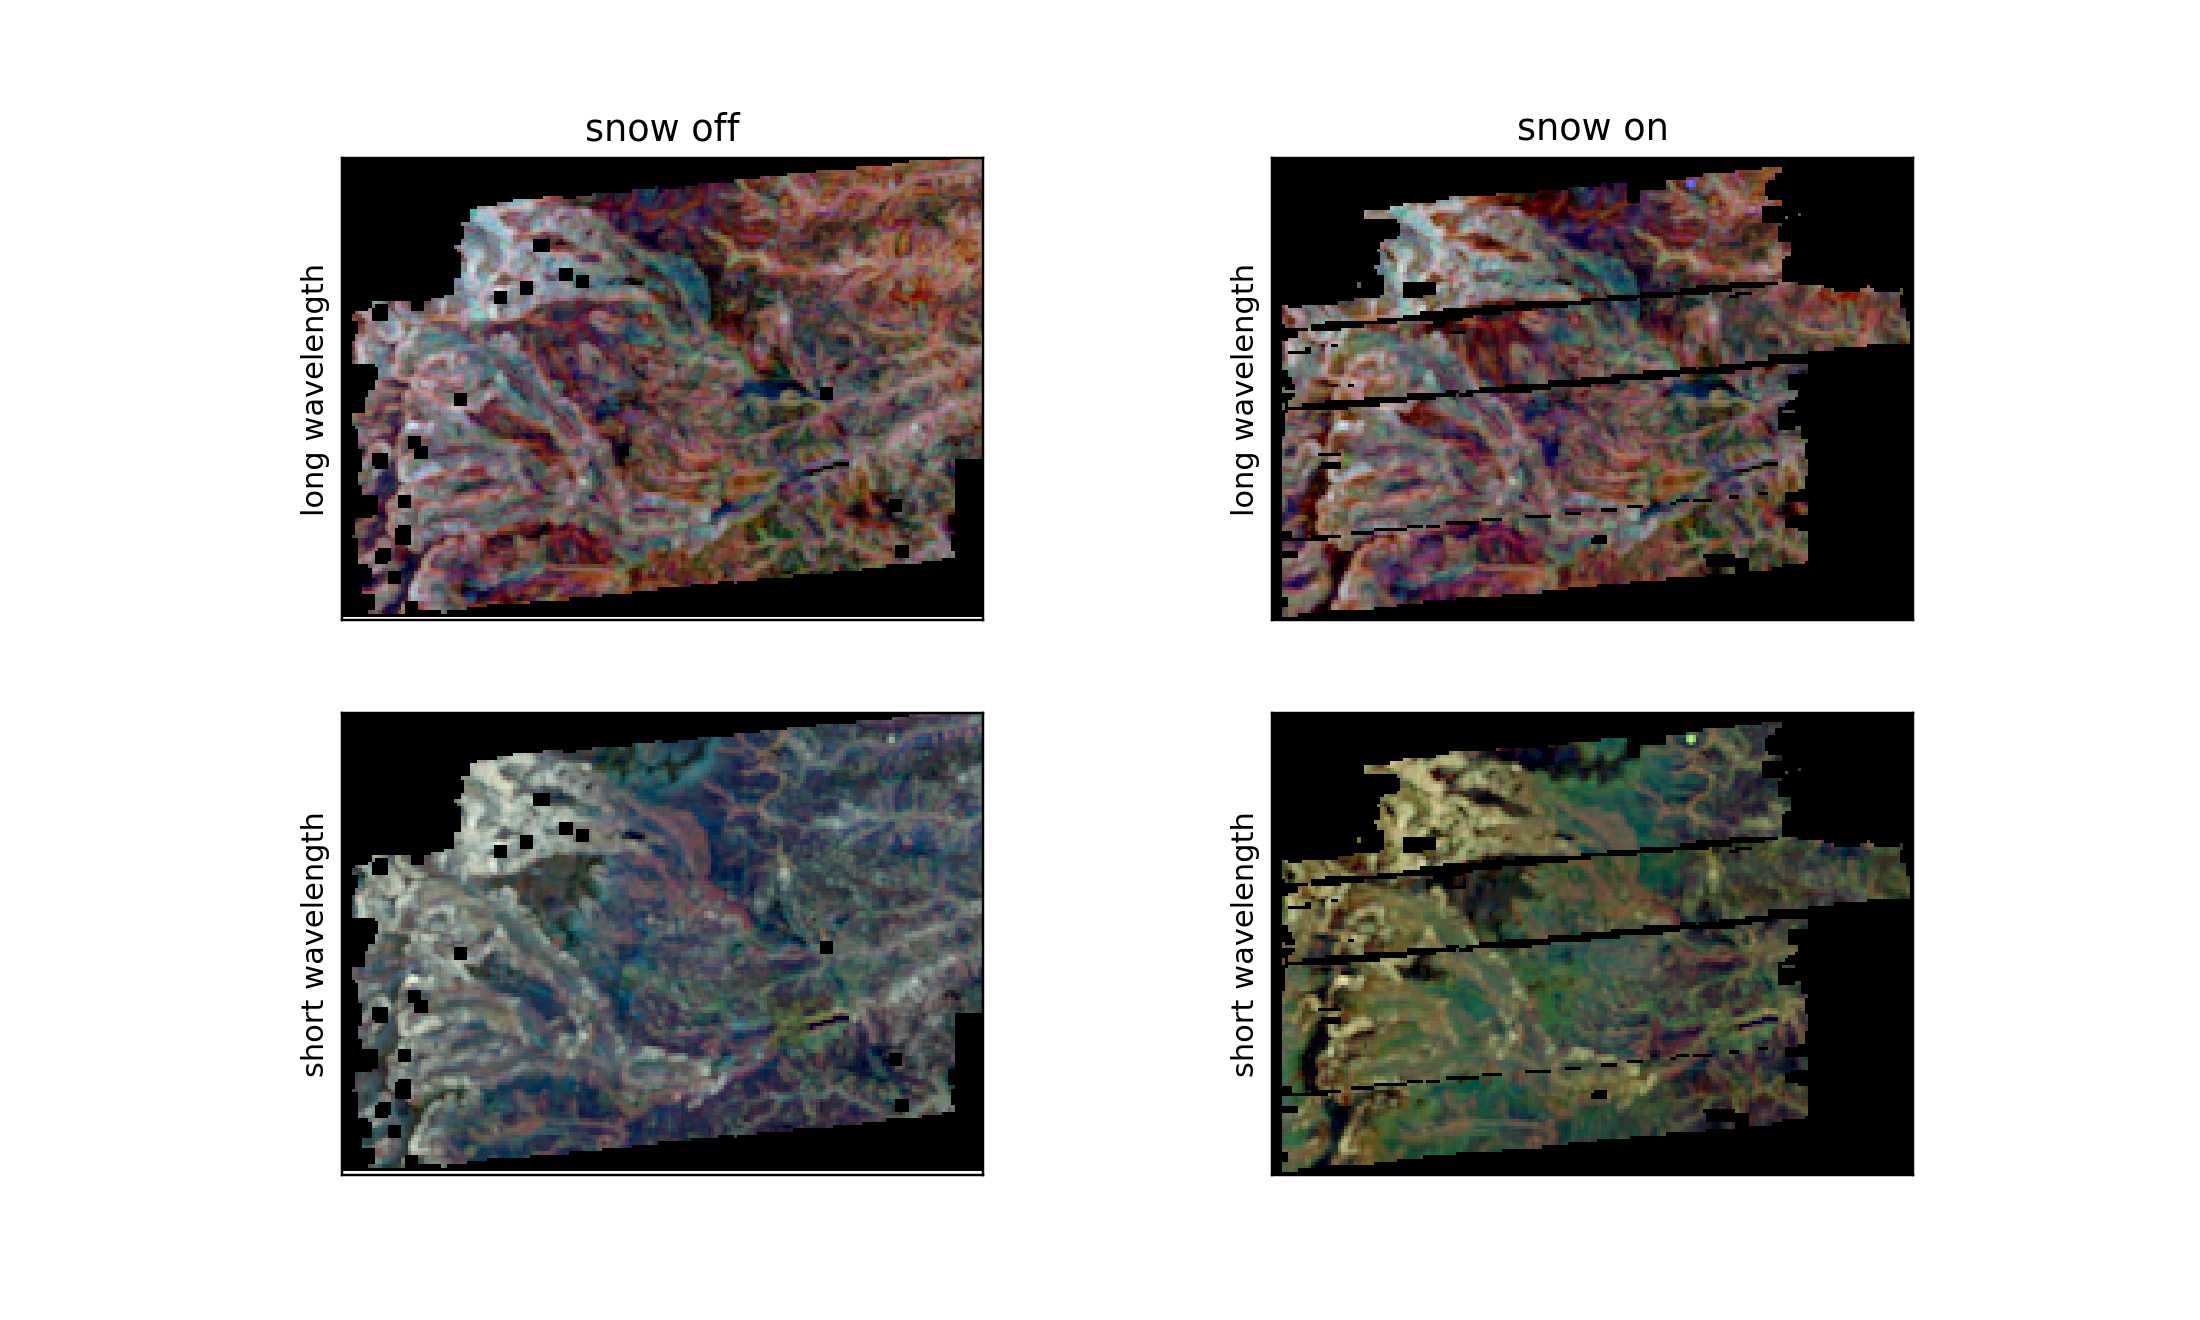

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [82]:
fig=plt.figure(figsize=[10, 6]); 
ax1=fig.add_subplot(221); 
plt.imshow((Pso.z[:,:,[7, 5, 3]]+5)/4, extent=Pso.extent, origin='lower');
plt.title('snow off')
plt.ylabel('long wavelength')
ax2=fig.add_subplot(222, sharex=ax1, sharey=ax1); 
plt.imshow((Psn.z[:,:,[7, 5, 3]]+5)/4, extent=Psn.extent, origin='lower');
plt.ylabel('long wavelength')
plt.title('snow on')

ax3=fig.add_subplot(223,  sharex=ax1, sharey=ax1); 
plt.imshow((Pso.z[:,:,[4, 2, 0]]+5)/4, extent=Pso.extent, origin='lower');
plt.ylabel('short wavelength')
ax4=fig.add_subplot(224, sharex=ax1, sharey=ax1); 
plt.imshow((Psn.z[:,:,[4, 2, 0]]+5)/4, extent=Psn.extent, origin='lower');
plt.ylabel('short wavelength')

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])


## Grand mesa:

In [4]:

Pso=pc.grid.data().from_geotif('/Volumes/ice2/ben/openTopography/GrandMesa/USGS_one_meter_CO_MesaCo_QL2_UTM12_P_fft2.tif')


<IPython.core.display.Javascript object>


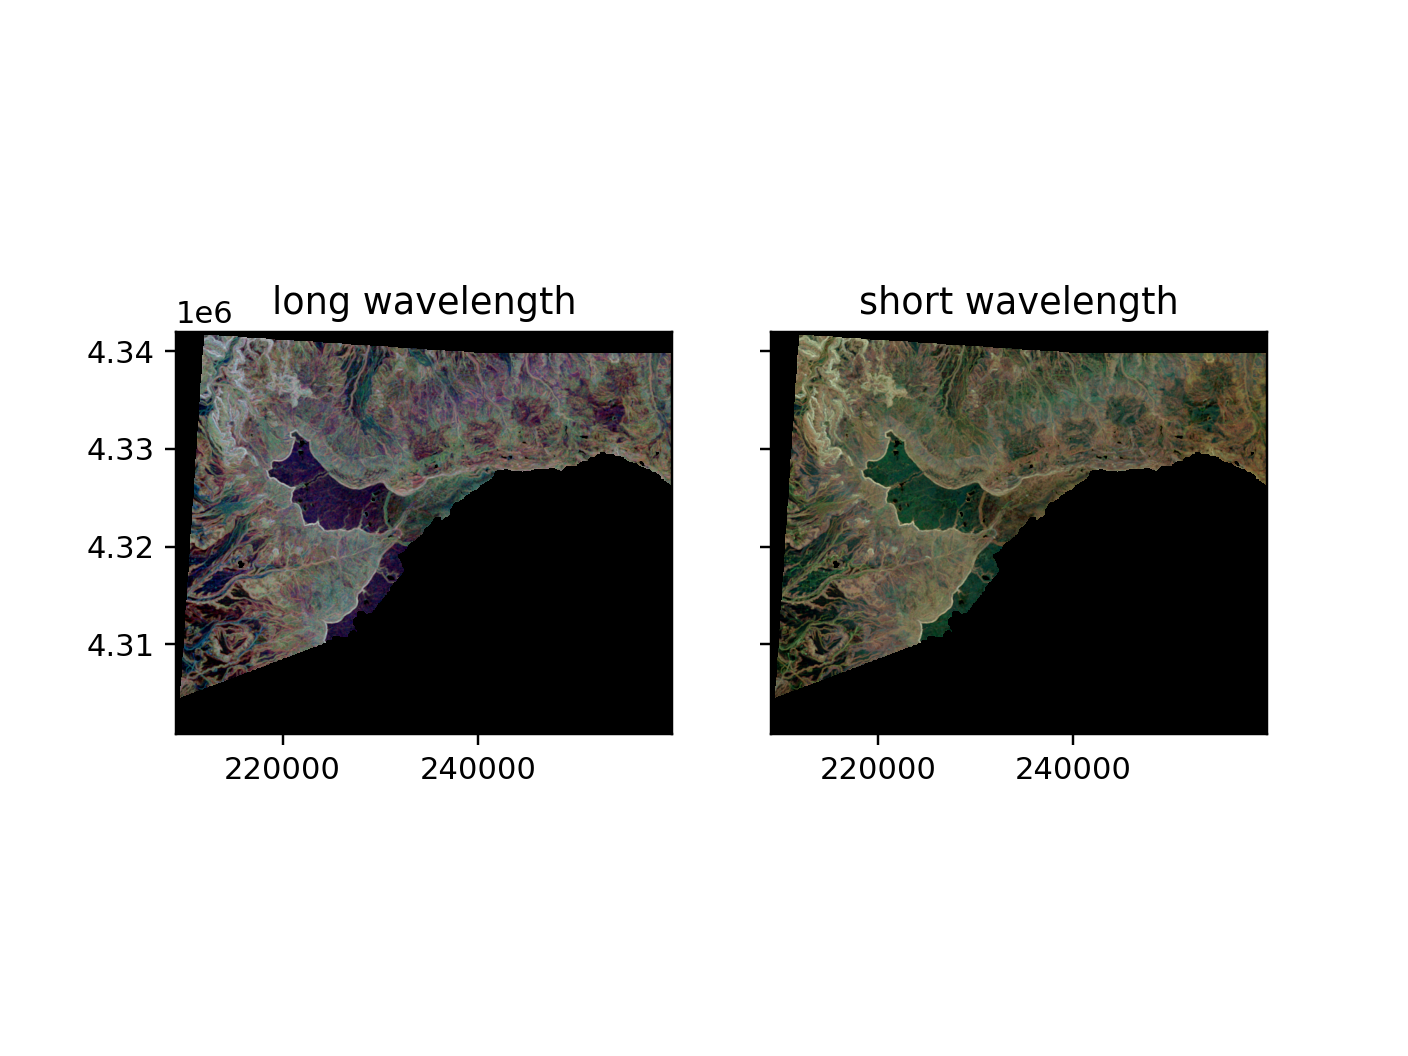

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'short wavelength')

In [12]:
fig=plt.figure()
ax=fig.subplots(1,2, sharex=True, sharey=True)
plt.sca(ax[0])
plt.imshow((Pso.z[:,:,[6, 4, 2]]+6)/6, extent=Pso.extent, origin='lower', 
           alpha=np.isfinite(Pso.z[:,:,-1]).astype(float));
plt.title('long wavelength')
plt.sca(ax[1])
plt.imshow((Pso.z[:,:,[4, 2, 0]]+6)/6, extent=Pso.extent, origin='lower', 
           alpha=np.isfinite(Pso.z[:,:,-1]).astype(float));
plt.title('short wavelength')
